In [1]:
import numpy as np
rng = np.random.default_rng(seed = 37)

import matplotlib.pyplot as plt
import os

import torch as t
import torch.nn as nn
from torchvision.transforms import v2
import torch.nn.functional as F

from tqdm import tqdm


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import sys
sys.path.append('utils')

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
print(f'Using {device} for inference')

KeyboardInterrupt: 

In [2]:
layer_num = 5
read_path = 'data/temp_inv_data/'
data_dir_list = [s for s in os.listdir(read_path) if f'layer-{layer_num:02d}' in s and '15-100-4-4-3-224-224' in s]

In [3]:
from utils.diffeo_container import diffeo_container

inv_grid = t.load(read_path + '15-100-4-4-3-224-224_inv_grid_sample.pt', map_location= t.device('cpu'))

inv_diffeos = diffeo_container(224, 224)
inv_diffeos.diffeos = inv_grid
down_sampled = inv_diffeos.up_down_sample(112, 112)

In [4]:
activation = t.empty((len(data_dir_list), 15, 100, 24, 112 * 112)) # shape of layer_num
for counter, file_path in enumerate(tqdm(data_dir_list)):
  raw_data = (t.load(read_path + file_path, map_location = t.device('cpu')))
  # activation[counter] = raw_data
  un_diff = F.grid_sample(raw_data, t.cat(list(down_sampled)))
  activation[counter] = F.normalize(un_diff.reshape(15, 100, 24, 112 * 112), dim = -1)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [12:31<00:00,  7.51s/it]


In [5]:
for counter, vector in enumerate(activation):
    activation[counter] = F.normalize(activation[counter], dim = -1)

In [6]:
dot_product_matrix = t.einsum('ijcx,ikcx ->ijk ', activation[:,0], activation[:,0])/24

In [63]:
un_diff.shape

torch.Size([1500, 24, 112, 112])

In [84]:
ref_path = 'data/reference/'
ref_file_path = 'val_image-0099_activation_layer-01.pt'
reference = (t.load(ref_path + ref_file_path, map_location = t.device('cpu')))

In [85]:
reference.shape

torch.Size([1, 24, 112, 112])

In [74]:
reference[0,0].max()

tensor(54.8727)

In [75]:
un_diff[0,0].max()

tensor(44.2800)

In [8]:
a = t.randn(4, 4, 4, 4)
t.mean(a, dim = (0,1,3)).shape

torch.Size([4])

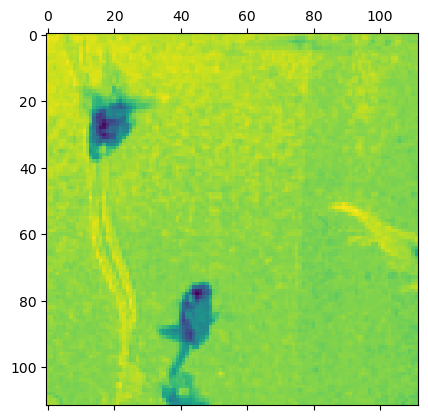

In [89]:
plt.matshow(reference[0,1])

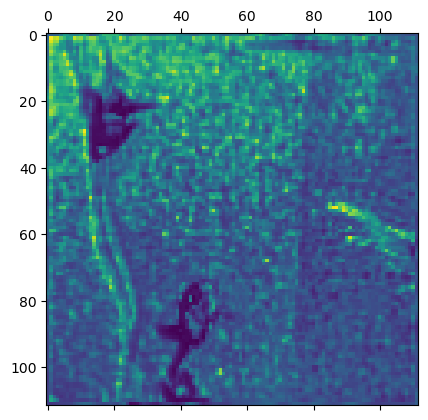

In [7]:
plt.matshow(un_diff[0,1])

Using cpu for inference
processing 5-th layer


/home/xj2173/vast/miniconda3/envs/diffeo/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/xj2173/vast/miniconda3/envs/diffeo/lib/python3.11/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: '/vast/xj2173/process_data/all_cnn_layers/cosine_similarity/all_layers.png'

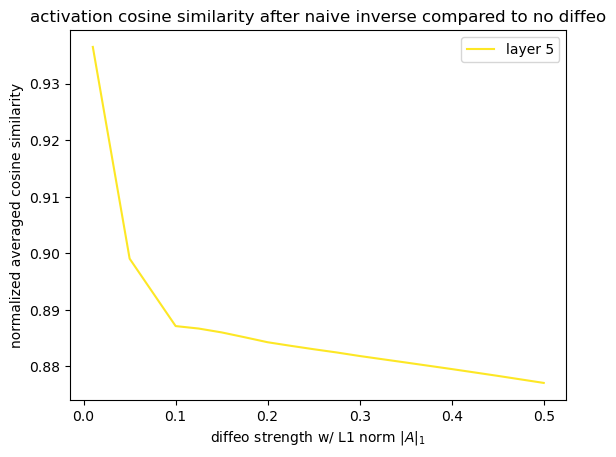

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch as t
import torch.nn.functional as F

import os
import sys
sys.path.append('utils')

from utils.diffeo_container import diffeo_container


device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
print(f'Using {device} for inference')

layer_num_list = [5]
read_path = '/vast/xj2173/diffeo/data/all_cnn_layers/'
save_path = '/vast/xj2173/diffeo/process_data/all_cnn_layers/cosine_similarity/'
ref_path =  '/vast/xj2173/diffeo/data/reference/'

inv_grid = t.load(read_path + '15-100-4-4-3-224-224_inv_grid_sample.pt', map_location= t.device('cpu'))
inv_diffeos = diffeo_container(224, 224)
inv_diffeos.diffeos = inv_grid

data_dir_list = []
ref_dir_list = []
for layer_num in layer_num_list:
    data_dir_list.append([s for s in os.listdir(read_path) if f'layer-{layer_num:02d}' in s and '15-100-4-4-3-224-224' in s])
    num_of_images = len(data_dir_list[-1])
    ref_dir_list.append([s for s in os.listdir(ref_path) if f'layer-{layer_num:02d}' in s][:num_of_images])


cosine_similarity_list = {}
for counter, (file_path_list, ref_path_list) in enumerate(zip(data_dir_list, ref_dir_list)):
    print(f'processing {layer_num_list[counter]}-th layer')
  
    activation = []
    ref_activation = []
    for file_path, ref_file_path in zip(file_path_list, ref_path_list):
        raw_data = t.load(read_path + file_path, map_location = t.device('cpu'))
        ref_data = t.load(ref_path + ref_file_path, map_location = t.device('cpu'))
        channels, x_res, y_res = raw_data.shape[-3:]
        if f'{x_res},{y_res}' not in inv_diffeos.resampled.keys():
           down_sampled = inv_diffeos.up_down_sample(x_res, y_res)

        un_diff = F.grid_sample(raw_data, t.cat(list(down_sampled)))
        activation.append(F.normalize(un_diff.reshape(15, 100, channels, x_res * y_res), dim = -1))
        ref_activation.append(F.normalize(ref_data.reshape(channels, x_res * y_res), dim = -1))
    
    activation = t.stack(activation) #img, strength, diffeo, channel, pixels
    ref_activation = t.stack(ref_activation)

    cosine_similarity = t.einsum('icp, isdcp -> isd', ref_activation, activation)/channels
    t.save(cosine_similarity, save_path + 'cosine_similarity' +f'_layer-{int(layer_num_list[counter]):02d}.pt')

    cosine_similarity_list[f'{layer_num_list[counter]}'] = t.mean(cosine_similarity, dim = (0,2))



diffeo_amp_list = [0.01, 0.05, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.35, 0.4, 0.45, 0.5]

plt.figure()

colors = plt.cm.viridis_r(np.linspace(0,1,len(cosine_similarity_list)))

for i, key in enumerate(cosine_similarity_list.keys()):
    layer_num = int(layer_num_list[i])
    plt.plot(diffeo_amp_list, cosine_similarity_list[key], color=colors[i], label = f'layer {layer_num}')
    plt.legend()
    plt.xlabel(r'diffeo strength w/ L1 norm $|A|_1$')
    plt.title('activation cosine similarity after naive inverse compared to no diffeo')
    plt.ylabel(r'normalized averaged cosine similarity')

plt.savefig(f'/vast/xj2173/process_data/all_cnn_layers/cosine_similarity/all_layers.png')
plt.close()

In [2]:
cosine_similarity_list

{'5': tensor([0.9365, 0.8991, 0.8871, 0.8867, 0.8860, 0.8852, 0.8843, 0.8837, 0.8830,
         0.8825, 0.8818, 0.8807, 0.8795, 0.8783, 0.8771])}

In [13]:
len(cosine_similarity_list)

1